## Interpretation of the MGPO strategy

This notebook contains an exemplary execution of the strategy discovered by MGPO and plots the belief state after termination. The figure final figure was created by annotating the order of actions in an image editing software.

In [1]:
from src.utils.experiment_creation import create_tree, create_init
from src.po_BMPS import analyse_generic
import numpy as np
import json
import seaborn as sns
import pandas as pd

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'gym'

In [2]:
TREE = create_tree(4, 2)
INIT = create_init(4, 2)
TAU = 0.005
COST = 0.05

In [4]:
df, states, _ = analyse_generic(TREE, INIT, TAU, COST, seed=6, max_actions=200)
df

,Action,VOC,Observation,ExpTermReward
0,15,3.232350,-8.138935,0.000000
1,30,3.232350,-14.028475,0.000000
2,45,3.232350,-17.093611,0.000000
3,60,2.054037,14.805989,9.870660
4,54,1.126647,-16.831765,9.870660
5,55,1.126647,29.686601,19.766193
6,47,0.307452,-18.636797,19.766193
7,48,0.307452,-32.962961,19.766193
8,49,0.307452,-2.708804,19.766193
9,50,0.237614,15.245872,21.460179


In [5]:
def get_action_indices(df, action):
    actions = df["Action"].tolist()
    indices = []
    for i, a in enumerate(actions):
        if a == action:
            indices.append(i+1)
    return indices

13.0


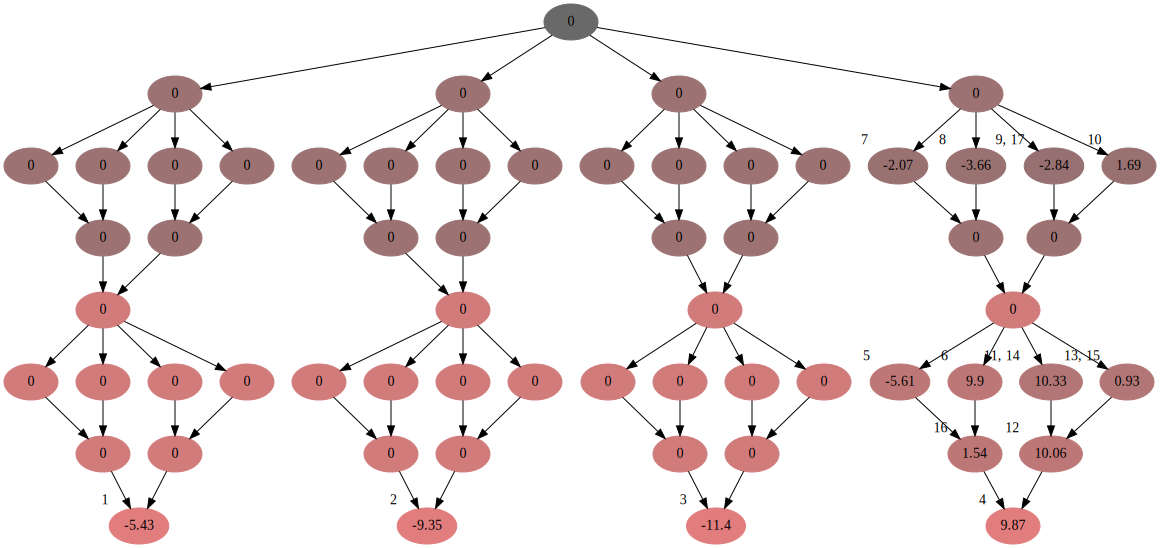

In [6]:
# https://stackoverflow.com/questions/25668828/how-to-create-colour-gradient-in-python
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    import matplotlib as mpl
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

def render(state, tree):
    from graphviz import Digraph
        
        
    def color(val):
        if val > 0:
            return '#8EBF87'
        else:
            return '#F7BDC4'
    
    max_sigma = np.round(max([x.sigma if hasattr(x, "sigma") else 0 for x in state]))+1
    print(max_sigma)
    dot = Digraph()
    for x, ys in enumerate(tree):
        if hasattr(state[x], "mu"):
            mean, sigma = state[x].mu, state[x].sigma
        else:
            mean, sigma = state[x], 0
        #observed = not hasattr(state[x], 'sample')
        #c = color(r) if observed else 'grey'
        c = colorFader("dimgrey", "lightcoral", mix=sigma/max_sigma)
        l = str(round(mean, 2)) #if observed else str(x)
        xl = ", ".join([str(x) for x in get_action_indices(df, x)])
        dot.node(str(x), label=l, style='filled', color=c, xlabel=xl)
        for y in ys:
            dot.edge(str(x), str(y))
    return dot

render(states[-1], TREE)

### Discrepancy evaluation
This section tests the discrepancy between the current MGPO version used in the simulation experiment and the previous MGPO version used the training experiment.

In [1]:
with open("./data/simulation_results/mgpo_optimization/4_2_0.05.json", "r") as f:
    cost_weight = json.load(f)["W"]

def compare_actions(a1, a2):
    min_length = min(len(a1), len(a2))
    for i in range(min_length):
        if a1[i] != a2[i]:
            return i
    return min_length


data = []
for i in range(500):
    # Old strategy
    df, states, reward_old = analyse_generic(TREE, INIT, TAU, COST, seed=i, max_actions=200, myopic_mode="old")
    actions_old = df["Action"].tolist()
    # New strategy
    df, states, reward_new = analyse_generic(TREE, INIT, TAU, COST, seed=i, max_actions=200, myopic_mode="normal", cost_weight=cost_weight)
    actions_new = df["Action"].tolist()
    data.append([i, compare_actions(actions_old, actions_new), len(actions_new), len(actions_old), reward_old, reward_new])
df = pd.DataFrame(data, columns=["Seed", "Identical actions", "ActionsNew", "ActionsOld", "RewardOld", "RewardNew"])


NameError: name 'json' is not defined

In [10]:
df.mean()

Seed                 249.500000
Identical actions      4.432000
ActionsNew            44.188000
ActionsOld            18.672000
RewardOld             26.367775
RewardNew             31.975063
dtype: float64

In [12]:
print(df["RewardNew"].mean()-df["RewardOld"].mean())

5.607287860756518


<AxesSubplot:xlabel='Identical actions', ylabel='Count'>

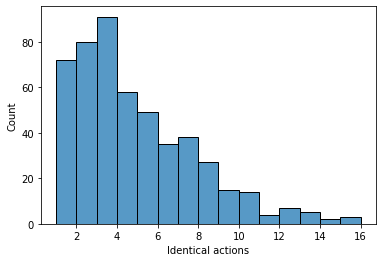

In [33]:
sns.histplot(df["Identical actions"])

### Outlier participant investigation

This section investigates participants that achive a high resource rationality score while also having a low click agreement

In [1]:
import pandas as pd

df = pd.read_csv("./data/tutor_experiment/tutor_experiment_exclusion_data.csv")
df.columns

Index(['Unnamed: 0', 'Participant', 'Condition', 'Counterbalance', 'TrialId',
       'Score', 'ExpectedScore', 'ClickedScore', 'NumClicks', 'Actions',
       'TestEnv', 'OptimalScore', 'ClickAgreement', 'RepeatAgreement',
       'StrictRepeatAgreement', 'TermAgreement', 'RepeatClicks', 'BmpsReward',
       'BmpsClick', 'BmpsRepeatClicks', 'BmpsActions', 'Cost', 'Tau',
       'BmpsGoalStrategy', 'GoalStrategy', 'Excluded'],
      dtype='object')

In [2]:

mean_participant_df = df[["Participant", "ClickAgreement", "ExpectedScore", "Condition"]].groupby("Participant").mean()
mean_participant_df["Condition"] = mean_participant_df["Condition"].astype('category')
mean_participant_df.head()

,ClickAgreement,ExpectedScore,Condition
Participant,,,
0,0.557333,21.823745,2.0
1,0.254430,23.617529,0.0
2,0.152024,8.487750,2.0
3,0.015385,7.892123,0.0
4,0.050000,0.093841,2.0


In [23]:
import plotly.express as px

avg_bmps = df["BmpsReward"].mean()

fig = px.scatter(mean_participant_df, x="ClickAgreement", y="ExpectedScore", 
                 title="Click agreement vs expected score per participant",
                 labels={"ClickAgreement": "Click Agreement", 
                        "ExpectedScore": "Expected Score"}, width=800)

# Add horizontal line for average BMPS score
fig.add_hline(y=avg_bmps, line_dash="dash", line_color="red",
              annotation_text=f"MGPS",
              annotation_position="top left")

fig.show()


In [4]:
# Calculate R-squared
from sklearn.linear_model import LinearRegression
import numpy as np
X = mean_participant_df["ClickAgreement"].values.reshape(-1, 1)
y = mean_participant_df["ExpectedScore"].values
model = LinearRegression()
model.fit(X, y)
r_squared = model.score(X, y)
print(f"R-squared: {r_squared:.3f}")

R-squared: 0.338


In [5]:
correlation = np.corrcoef(mean_participant_df["ClickAgreement"], mean_participant_df["ExpectedScore"])[0,1]
print(f"Correlation: {correlation:.3f}")

Correlation: 0.581


In [6]:
top_participants = mean_participant_df[mean_participant_df["ClickAgreement"] < 0.2]
top_participants = top_participants.sort_values(by="ExpectedScore", ascending=False).head(10)
top_participant_ids = top_participants.index.tolist()
print(top_participants)

             ClickAgreement  ExpectedScore Condition
Participant                                         
297                0.104207      27.924483       2.0
446                0.191668      27.033175       1.0
78                 0.184985      26.559571       0.0
412                0.164454      24.354637       1.0
246                0.067508      24.209027       0.0
476                0.190599      22.914151       1.0
123                0.141797      22.597859       2.0
369                0.110924      22.591087       0.0
317                0.189791      22.439968       0.0
383                0.075690      22.236854       0.0


In [15]:
# Calculate average number of actions and BMPS actions for top participants
avg_actions = df[df["Participant"].isin(top_participant_ids)]["NumClicks"].mean()
avg_bmps_actions = df[df["Participant"].isin(top_participant_ids)]["BmpsClick"].mean()

print(f"Average number of actions for top participants: {avg_actions:.2f}")
print(f"Average number of BMPS actions for top participants: {avg_bmps_actions:.2f}")


Average number of actions for top participants: 55.16
Average number of BMPS actions for top participants: 20.35


In [17]:
top_participant_scores = df[df["Participant"].isin(top_participant_ids)]["Score"].to_numpy()
bmps_scores = df[df["Participant"].isin(top_participant_ids)]["BmpsReward"].to_numpy()
avg_participant_score = df[df["Participant"].isin(top_participant_ids)]["Score"].mean()
avg_bmps_score = df[df["Participant"].isin(top_participant_ids)]["BmpsReward"].mean()

print(f"Average reward for top participants: {avg_participant_score:.2f}")
print(f"Average bmps reward on same trials: {avg_bmps_score:.2f}")

Average reward for top participants: 24.29
Average bmps reward on same trials: 22.34


In [19]:
from scipy.stats import shapiro

stat, p_value = shapiro(top_participant_scores)
print(f"Statistic: {stat}, p-value: {p_value}")

stat, p_value = shapiro(bmps_scores)
print(f"Statistic: {stat}, p-value: {p_value}")

Statistic: 0.9795857071876526, p-value: 0.12340910732746124
Statistic: 0.9762158989906311, p-value: 0.06719156354665756


In [22]:
from scipy.stats import ttest_rel

stat, p_value = ttest_rel(top_participant_scores, bmps_scores)
print(f"Statistic: {stat}, p-value: {p_value}")

Statistic: 1.5378783701834589, p-value: 0.12726846613179507
